##1.Setup

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from dateutil import parser
from collections import Counter
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.7MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1OyY_y2jC6UrPz1gJLC3_Oz7ZxZECTWp9'

In [0]:
fluff, _id = link.split('=')
downloaded = drive.CreateFile({'id':_id}) 
downloaded.GetContentFile('situationcreated.csv')  
df_conversation = pd.read_csv('situationcreated.csv')

In [0]:
link = 'https://drive.google.com/open?id=1CnD_08p3z9dBiOWMNheBah4gnP7XnddK'

In [0]:
fluff, _id = link.split('=')
downloaded = drive.CreateFile({'id':_id}) 
downloaded.GetContentFile('users.csv')  
df_users = pd.read_csv('users.csv')

In [13]:
df_users.head()

,index,$distinct_id,age,daily_notification,gender,occupation,personality_type
0,0,E185ACD01070418FAC3A34186C1C00B1,22,NaN,male,Student full time,ENFPT
1,1,2921AB4622F14F548E5285C72AD4D984,28,21:30,male,Student full time,INFPA
2,2,03D71DB1C8934F13B45D3724FD1A2317,44,NaN,male,Work and attend school,INTJT
3,3,35E2C305385B49CB8BCB338FB2C2E648,39,NaN,female,Employed full time,INTPT
4,4,F4D57C4A448F4F3F885B7C5722B1207D,27,12:30,male,Freelancer or work part time,INFJT


## 2. Data Prep

### 2.1 Function

In [0]:
def try_jl(x):
    try:
        return json.loads(x)
    except: #FIX ME FIND ERROR
        return [x]
        
def parse_dailyreminder(x):
    try:
        return parser.parse(x)
    except AttributeError:
        return np.nan
    except ValueError:
        return np.nan
        
def hour_dailyreminder(x):
    try:
        return x.hour
    except AttributeError:
        return np.nan

def hour_dailyreminder(x):
    try:
        return x.hour
    except AttributeError:
        return np.nan
  
def minutes_dailyreminder(x):
  try:
    return x.minute
  except AttributeError:
    return np.nan
  
def dailyreminder_null(x):
  if math.isnan(x):
    return 1
  else:
    return 0
  

In [0]:
def preprocessing(df_conversation, df_users):
    
    
    #DATA PREP CONVERSATION------------------------------
    
    df_conversation['timestamp_datetime'] = df_conversation['timestamp'].apply(lambda x: parser.parse(x))
    
    df_conversation['thinking_traps']= (df_conversation['thinking_traps']
                                        .fillna('[]')
                                        .apply(lambda x: x.replace("'", '"'))
                                        .apply(json.loads)
                                        .apply(lambda x: list(set(x))))
    thinkintraps_expand = (df_conversation["thinking_traps"]
                           .apply(lambda x: Counter(x))
                           .apply(pd.Series)
                           .fillna(0)
                           .add_prefix('thinking_traps_'))
    df_conversation = df_conversation.join(thinkintraps_expand)
    
    df_conversation['factors']= (df_conversation['factors']
                                        .fillna('[]')
                                        .apply(lambda x: x.replace("'", '"'))
                                        .apply(try_jl)
                                        .apply(lambda x: list(set(x))))
    topic_expand = (df_conversation["factors"]
                    .apply(lambda x: Counter(x))
                    .apply(pd.Series)
                    .fillna(0)
                    .add_prefix('factors_'))
    df_conversation = df_conversation.join(topic_expand)
    
    df_conversation['$os'] = df_conversation['$os'].replace({'iOS': 0, 'Android': 1})
    
    df_conversation['conversation_result'] = df_conversation['conversation_result'].replace({'Positive': 1, 'Negative': 0})
    
    df_conversation = pd.get_dummies(df_conversation, columns = ['emotion'])
    
    
    
    #DATA PREP USERS-----------------------------------
    
    df_users['datetime_dailyreminder'] = df_users['daily_notification'].apply(parse_dailyreminder)
    
    df_users['gender'] = df_users['gender'].replace({'male': 1, 'female': 0})
    
    df_users['occupation'] = df_users['occupation'].fillna('not_informed')
    
    df_users = pd.get_dummies(df_users, columns = ['occupation', 'personality_type'])
    
    #FEATURE CREATION CONVERSATION-------------------------
    
    df_conversation['timestamp_date'] = df_conversation['timestamp_datetime'].apply(lambda x: x.date())
    df_conversation['timestamp_year'] = df_conversation['timestamp_datetime'].apply(lambda x: x.year)
    df_conversation['timestamp_time'] = df_conversation['timestamp_datetime'].apply(lambda x: x.time())
    df_conversation['timestamp_hour'] = df_conversation['timestamp_time'].apply(lambda x: x.hour)
    df_conversation['timestamp_month'] = df_conversation['timestamp_datetime'].apply(lambda x: x.month)
    
    df_conversation['thinkingtraps_len'] = df_conversation['thinking_traps'].apply(lambda x: len(x))

    df_conversation['topic_len'] = df_conversation['factors'].apply(lambda x: len(x))
    
    
    #FEATURE CREATION USERS---------------------------------
    df_users['hour_dailyreminder'] = df_users['datetime_dailyreminder'].apply(hour_dailyreminder)
    df_users['minutes_dailyreminder'] = df_users['datetime_dailyreminder'].apply(minutes_dailyreminder)
    df_users['totalminutes_dailyreminder'] = df_users['minutes_dailyreminder']+60*df_users['hour_dailyreminder']
    df_users['dailyreminder_isnull'] = df_users['hour_dailyreminder'].apply(dailyreminder_null)
    
    #DROP COLS E JOIN----------------------------------
    
    df_conversation = df_conversation.drop(['index', 'thinking_traps', 
                                        'factors', 'timestamp_datetime', 'timestamp_date', 'timestamp_time', 'timestamp'], axis =1)

    df_users = df_users.drop(['index', 'datetime_dailyreminder','daily_notification'], axis = 1)
    
    feature_matrix = (df_conversation.set_index('distinct_id').join(df_users.set_index('$distinct_id'), how = 'left')
                      .dropna(subset = ['gender'])
                      .reset_index()
                      .drop(['index'], axis =1)
                      .fillna(0))
    
    return feature_matrix

###2.2 Run

In [0]:
feature_matrix = preprocessing(df_conversation, df_users)

In [0]:
y = feature_matrix['conversation_result']
X = feature_matrix.drop(['conversation_result'], axis =1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3.Model

### 3.1 Random Forest

In [0]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1)

In [42]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_rf_opt = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
clf_rf_opt.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/skl

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
clf_rf_opt.best_params_ #={'bootstrap': True,'max_depth': 20, 'max_features': 'auto','min_samples_leaf': 1,'min_samples_split': 5,'n_estimators': 250}

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 250}

In [0]:
clf_rf = RandomForestClassifier(n_estimators=250, min_samples_split= 5, min_samples_leaf = 1,max_depth = 20, bootstrap = True, random_state=0, n_jobs = -1)

In [56]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### 3.2 Logistic Regression

In [43]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
clf_log = LogisticRegression()

In [45]:
clf_log.fit(X_train_sc, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## 4. Metrics

### 4.1 Function

In [0]:
def metrics_report(X_test, y_test, clf):
  return {'accuracy': accuracy_score(y_test, clf.predict(X_test)), 
          'precision': precision_score(y_test, clf.predict(X_test)), 
          'recall': recall_score(y_test, clf.predict(X_test)),
          'f1': f1_score(y_test, clf.predict(X_test)),
          'roc_auc': roc_auc_score(y_test, clf.predict(X_test))}

### 4.2 Eval

In [48]:
metrics_rf = metrics_report(X_test, y_test, clf_rf)
metrics_rf

{'accuracy': 0.7174090594961362,
 'f1': 0.6616349047141424,
 'precision': 0.6469376746922963,
 'recall': 0.6770154461948992,
 'roc_auc': 0.7111372164458787}

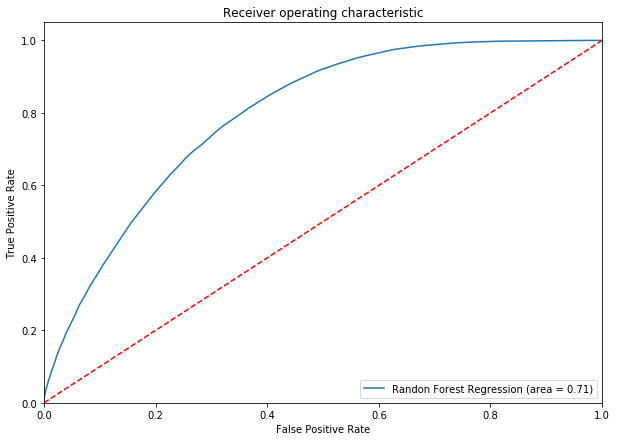

In [49]:
logit_roc_auc = roc_auc_score(y_test, clf_rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, label='Randon Forest Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [50]:
metrics_log = metrics_report(X_test_sc, y_test, clf_log)
metrics_log

{'accuracy': 0.6602793658771544,
 'f1': 0.5075886352598349,
 'precision': 0.6213123281563498,
 'recall': 0.42905526761430696,
 'roc_auc': 0.6243776196548749}

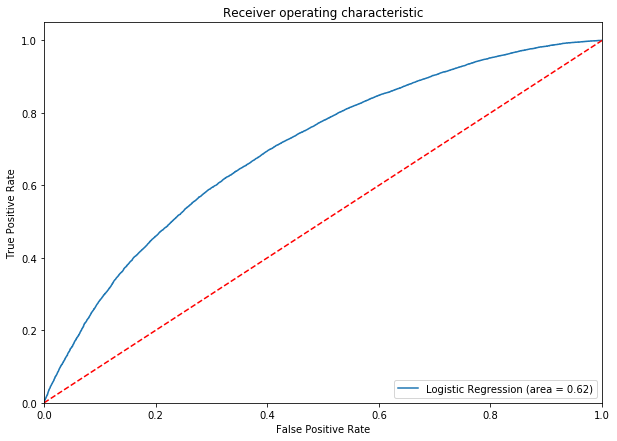

In [51]:
logit_roc_auc = roc_auc_score(y_test, clf_log.predict(X_test_sc))
fpr, tpr, thresholds = roc_curve(y_test, clf_log.predict_proba(X_test_sc)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
feature_matrix.shape

(372373, 127)

## 5. Model Interpretation

In [52]:
feature_importances = pd.DataFrame(clf_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
conversation_duration,0.193109
age,0.055643
timestamp_hour,0.055461
emotion_level,0.054769
topic_len,0.037203
thinkingtraps_len,0.027855
totalminutes_dailyreminder,0.020894
timestamp_month,0.020104
emotion_depression,0.018458
hour_dailyreminder,0.017081


In [0]:
logreg_weights = pd.DataFrame(clf_log.coef_.T, index = list(X.columns), columns = ['weight'])

In [54]:
logreg_weights.sort_values('weight', ascending = False)

,weight
emotion_boredom,0.740584
conversation_duration,0.570111
emotion_tiredness,0.470183
age,0.453578
emotion_insecurity,0.292815
emotion_numbness,0.283585
occupation_Homemaker,0.276059
personality_type_ESTJA,0.261091
thinking_traps_Negative Glasses,0.259159
emotion_stress,0.245080


In [0]:
X.columns.shape

(126,)